# Simple Performance Benchmark on EasyOCR


In [ ]:
!pip install easyocr tqdm

## Gather test image

In [2]:
import requests
from PIL import Image
from io import BytesIO


def get_img_from_url(url: str) -> Image.Image:
    """
    Fetches an image from the given URL and returns it as a PIL Image object.

    Args:
        url (str): The URL of the image to fetch.

    Returns:
        Image.Image: The fetched image as a PIL Image object.
    """
    response = requests.get(url)

    if response.status_code == 200:
        img = Image.open(BytesIO(response.content))
        return img
    else:
        print(f"Failed to retrieve image. Status code: {response.status_code}")

In [3]:
img_url = "https://capacity.com/wp-content/uploads/2023/03/2023-IDP-vs-OCR-Definition-OCR-1024x543.jpg"
img = get_img_from_url(img_url)

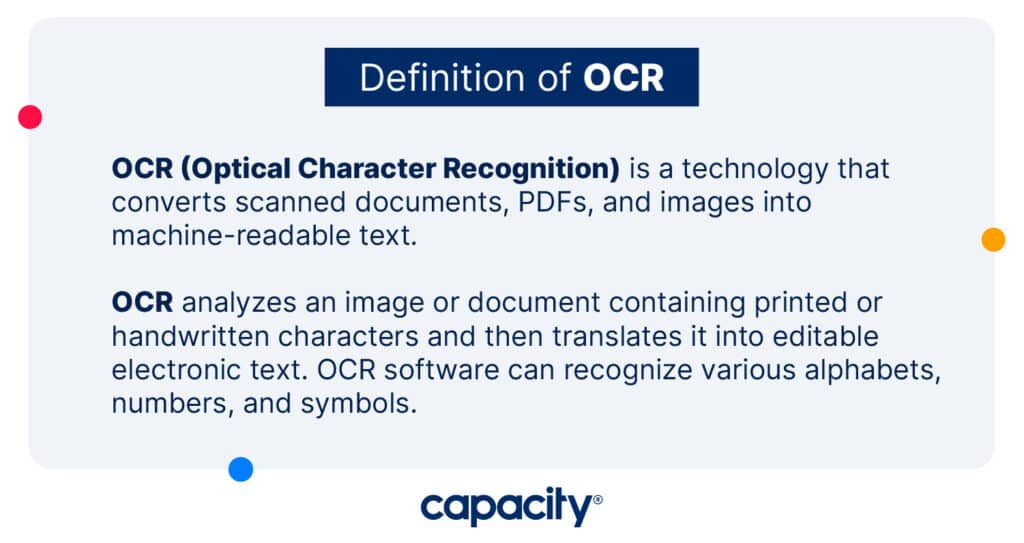

In [4]:
img

## Setup simple benchmark on EasyOCR

In [5]:
import time
import easyocr
import multiprocessing
from tqdm import tqdm


def benchmark_inference(
    n_samples: int = 100, gpu: bool = True, n_workers: int = 0, batch_size: int = 1
) -> dict:
    """
    Benchmark the inference speed of the easyocr.Reader.

    Args:
        n_samples (int): Number of images to process.
        gpu (bool): Whether to use GPU for inference.
        n_workers (int): Number of worker processes for parallel processing.
        batch_size (int): Number of images to process in each batch.

    Returns:
        dict: A dictionary containing the benchmark results including:
            - n_samples (int): Number of images processed.
            - gpu (bool): Whether GPU was used for inference.
            - n_workers (int): Number of worker processes used.
            - batch_size (int): Batch size used for processing.
            - total_time (float): Total time taken for processing.
            - img_per_sec (float): Number of images processed per second.
    """
    reader = easyocr.Reader(lang_list=["en"], gpu=gpu)

    start_time = time.time()
    for i in tqdm(range(0, n_samples, batch_size)):
        if batch_size <= 1:
            result = reader.readtext(img, workers=n_workers)
        else:
            current_batch_size = min(batch_size, n_samples - i)
            result = reader.readtext_batched(
                [img] * current_batch_size, workers=n_workers
            )

    total_time = time.time() - start_time
    ips = n_samples / total_time

    print(f"Processed {n_samples} images in {total_time} seconds at {ips}.")

    return {
        "n_samples": n_samples,
        "gpu": gpu,
        "n_workers": n_workers,
        "batch_size": batch_size,
        "total_time": total_time,
        "img_per_sec": ips,
    }

In [40]:
benchmark_inference(n_samples=10, gpu=True, n_workers=0, batch_size=2)

100%|██████████| 10/10 [00:02<00:00,  3.46it/s]

Processed 10 images in 2.892890453338623 seconds at 3.456750319895181.


{'n_samples': 10,
 'batch_size': 2,
 'total_time': 2.892890453338623,
 'img_per_sec': 3.456750319895181}

## Run experiments of set of hyper params

In [6]:
def run_experiments():
    """
    Run experiments to benchmark inference performance.

    Returns:
        results (list): List of benchmark results.
    """
    results = []

    for gpu in [True, False]:
        for n_workers in [0, multiprocessing.cpu_count()]:
            for batch_size in [1, 4, 8, 16, 32, 64]:
                try:
                    result = benchmark_inference(
                        n_samples=50,
                        gpu=gpu,
                        n_workers=n_workers,
                        batch_size=batch_size,
                    )
                    results.append(result)
                except:
                    results.append("FAIL")

    return results

In [7]:
results = run_experiments()

100%|██████████| 50/50 [00:14<00:00,  3.52it/s]


Processed 50 images in 14.211288928985596 seconds at 3.518329706042294.


100%|██████████| 13/13 [00:12<00:00,  1.04it/s]


Processed 50 images in 12.491449117660522 seconds at 4.002738155440232.


100%|██████████| 7/7 [00:11<00:00,  1.71s/it]


Processed 50 images in 11.98819088935852 seconds at 4.170771091439925.


100%|██████████| 4/4 [00:11<00:00,  2.97s/it]


Processed 50 images in 11.892279386520386 seconds at 4.204408454839516.


100%|██████████| 2/2 [00:12<00:00,  6.03s/it]


Processed 50 images in 12.059099435806274 seconds at 4.146246597116395.


100%|██████████| 1/1 [00:12<00:00, 12.35s/it]


Processed 50 images in 12.35270643234253 seconds at 4.047695966374403.


100%|██████████| 50/50 [01:34<00:00,  1.88s/it]


Processed 50 images in 94.06160140037537 seconds at 0.5315665399653771.


100%|██████████| 13/13 [01:29<00:00,  6.89s/it]


Processed 50 images in 89.59738111495972 seconds at 0.5580520253805912.


100%|██████████| 7/7 [01:35<00:00, 13.61s/it]


Processed 50 images in 95.24053025245667 seconds at 0.5249865773265189.


100%|██████████| 4/4 [01:34<00:00, 23.54s/it]


Processed 50 images in 94.16355228424072 seconds at 0.530991012839774.


100%|██████████| 2/2 [01:33<00:00, 46.74s/it]


Processed 50 images in 93.48638653755188 seconds at 0.5348372298026072.


100%|██████████| 1/1 [01:33<00:00, 93.59s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 93.59464263916016 seconds at 0.5342186111310597.


100%|██████████| 50/50 [02:06<00:00,  2.53s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 126.68115043640137 seconds at 0.39469171086429194.


100%|██████████| 13/13 [02:11<00:00, 10.10s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 131.25495171546936 seconds at 0.3809380091685115.


100%|██████████| 7/7 [02:09<00:00, 18.52s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 129.62717151641846 seconds at 0.385721599993926.


100%|██████████| 4/4 [02:09<00:00, 32.46s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 129.83220553398132 seconds at 0.38511245953465195.


100%|██████████| 2/2 [02:12<00:00, 66.19s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 132.38873839378357 seconds at 0.3776756286571562.


100%|██████████| 1/1 [02:12<00:00, 132.18s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 132.17972445487976 seconds at 0.3782728418159758.


100%|██████████| 50/50 [04:20<00:00,  5.22s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 260.76268315315247 seconds at 0.19174522748193132.


100%|██████████| 13/13 [04:13<00:00, 19.51s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 253.6054711341858 seconds at 0.19715662984866908.


100%|██████████| 7/7 [04:17<00:00, 36.84s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 257.894490480423 seconds at 0.19387773622793059.


100%|██████████| 4/4 [04:18<00:00, 64.68s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 258.7206687927246 seconds at 0.193258622255873.


100%|██████████| 2/2 [04:15<00:00, 127.83s/it]
Using CPU. Note: This module is much faster with a GPU.


Processed 50 images in 255.65750002861023 seconds at 0.19557415680902995.


100%|██████████| 1/1 [04:19<00:00, 259.20s/it]

Processed 50 images in 259.1988036632538 seconds at 0.19290212490702333.


In [9]:
import json


def save_to_jsonl(data, filename: str):
    """
    Save data to a JSONL file.

    Args:
        data (list): The data to be saved.
        filename (str): The name of the file to save the data to.
    """
    with open(filename, "w") as file:
        for item in data:
            file.write(json.dumps(item) + "\n")

    print(f"Data saved to {filename}")

In [10]:
filename = "results.jsonl"
save_to_jsonl(results, filename)

Data saved to results.jsonl


## Visualize results

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [28]:
df = pd.read_json(filename, lines=True)
df = df[df.n_workers == 0].loc[:, ["gpu", "batch_size", "total_time", "img_per_sec"]]

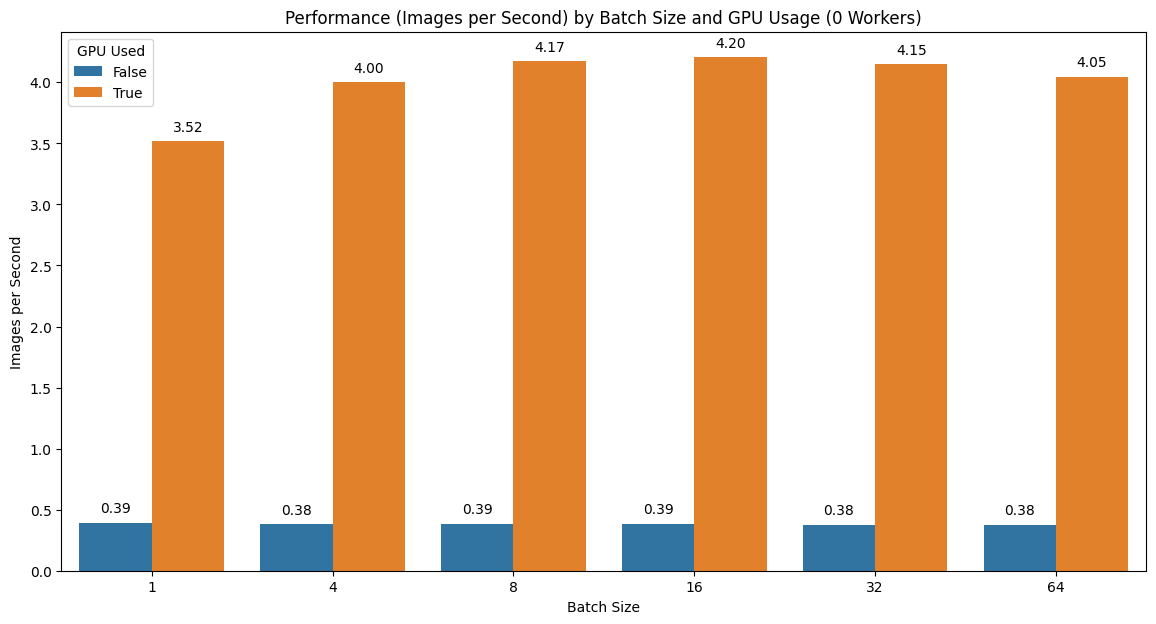

In [29]:
# Plotting how GPU usage affects performance
plt.figure(figsize=(14, 7))
barplot = sns.barplot(x="batch_size", y="img_per_sec", hue="gpu", data=df)
plt.title("Performance (Images per Second) by Batch Size and GPU Usage (0 Workers)")
plt.xlabel("Batch Size")
plt.ylabel("Images per Second")
plt.legend(title="GPU Used")

# Adding the text on the bars
for p in barplot.patches:
    barplot.annotate(
        format(
            p.get_height(), ".2f"
        ),  # The text to display (formatted to 2 decimal places here)
        (
            p.get_x() + p.get_width() / 2.0,
            p.get_height(),
        ),  # The position of the text (center, top)
        ha="center",  # Center alignment
        va="center",  # Center alignment
        xytext=(0, 10),  # Distance from the top of the bar
        textcoords="offset points",
    )

plt.show()